# Import Dependencies

In [432]:
# System
import os

# Data Analysis
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

import tensorflow as tf

import csv
import pickle

# Get Data

In [433]:
file_path = os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/cutfree-simulations/runtime_data_v2.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()
df.iloc[0]

Oligo                        NNNNNN
OligoLength                       6
Sites                   Any["YATR"]
TotalSites                        1
SiteLength                        4
CutFree_Randomer             NBNVVN
CutFree_Degeneracy          7.45472
CutFree_Time               0.006211
CutFreeRL_Randomer           NNVVVN
CutFreeRL_Degeneracy        7.45472
CutFreeRL_Time             0.228063
Name: 0, dtype: object

In [434]:
df.loc[(df["OligoLength"] == 6) & (df["TotalSites"] == 1) & (df["SiteLength"] == 4)]

,Oligo,OligoLength,Sites,TotalSites,SiteLength,CutFree_Randomer,CutFree_Degeneracy,CutFree_Time,CutFreeRL_Randomer,CutFreeRL_Degeneracy,CutFreeRL_Time
0,NNNNNN,6,"Any[""YATR""]",1,4,NBNVVN,7.454720,0.006211,NNVVVN,7.454720,0.228063
1750,NNNNNN,6,"Any[""GATC""]",1,4,HNNNDD,7.454720,0.006383,NNNDDD,7.454720,0.225150
3500,NNNNNN,6,"Any[""GGCC""]",1,4,NHNNDN,7.742402,0.007255,NNNDND,7.742402,0.080954


# Data Classification

In [435]:
random_state = np.random.randint(0, 10000)
random_state

2603

In [436]:
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]

values = [0, 1] # 0 = CutFree, 1 = CutFreeRL

df["Algorithm"] = np.select(conditions, values)
df = df[["OligoLength", "TotalSites", "SiteLength", "Algorithm", "CutFree_Time", "CutFreeRL_Time"]]
df

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
0,6,1,4,0,0.006211,0.228063
1,6,2,4,0,0.007820,0.087950
2,6,3,4,0,0.010071,0.136403
3,6,4,4,0,0.013531,0.150443
4,6,5,4,0,0.013882,0.183784
...,...,...,...,...,...,...
5244,40,6,8,1,12.737720,4.200124
5245,40,7,8,1,60.120769,3.009765
5246,40,8,8,1,60.379011,3.989743
5247,40,9,8,1,60.156297,3.611050


# Rejection Sampling

In [437]:
numCutFree = df[df.Algorithm == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Algorithm == 1].shape[0]
print(numCutFreeRL)

3731
1518


In [438]:
df_rejection = df[df.Algorithm == 0].sample(numCutFree-numCutFreeRL, random_state=random_state)
df = df.drop(df_rejection.index)
df

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
0,6,1,4,0,0.006211,0.228063
3,6,4,4,0,0.013531,0.150443
5,6,6,4,0,0.011498,0.194223
6,6,7,4,0,0.018870,0.205003
9,6,10,4,0,0.021175,0.262876
...,...,...,...,...,...,...
5244,40,6,8,1,12.737720,4.200124
5245,40,7,8,1,60.120769,3.009765
5246,40,8,8,1,60.379011,3.989743
5247,40,9,8,1,60.156297,3.611050


In [439]:
numCutFree = df[df.Algorithm == 0].shape[0]
print(numCutFree)

numCutFreeRL = df[df.Algorithm == 1].shape[0]
print(numCutFreeRL)

1518
1518


In [440]:
df_total = df.copy()
df = df[["OligoLength", "TotalSites", "SiteLength", "Algorithm"]]

# Visualize Data

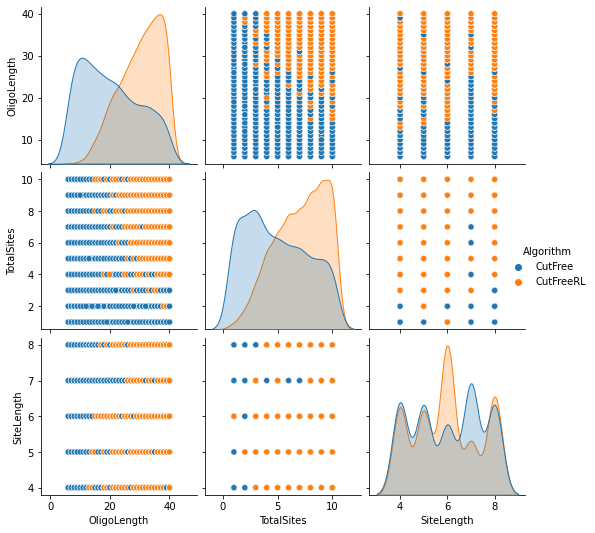

In [441]:
pair_plot = sns.pairplot(df, hue="Algorithm", diag_kind="kde")
new_labels = ["CutFree", "CutFreeRL"]
for t, l in zip(pair_plot._legend.texts, new_labels):
    t.set_text(l)
plt.show(pair_plot)

# Get Train/Test Split

In [442]:
x = df.drop(["Algorithm"], axis=1)
y = df["Algorithm"]

In [443]:
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x, y, test_size=0.2, random_state=random_state)
x_train_df.head()

,OligoLength,TotalSites,SiteLength
4197,19,8,8
852,23,3,4
2399,18,10,8
2972,30,3,6
4356,23,7,4


In [444]:
y_train_df.head()

4197    1
852     0
2399    1
2972    1
4356    1
Name: Algorithm, dtype: int32

In [445]:
x_train, y_train = tf.convert_to_tensor(x_train_df, dtype=tf.float32), tf.convert_to_tensor(y_train_df, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test_df, dtype=tf.float32), tf.convert_to_tensor(y_test_df, dtype=tf.float32)

In [446]:
x_train

<tf.Tensor: shape=(2428, 3), dtype=float32, numpy=
array([[19.,  8.,  8.],
       [23.,  3.,  4.],
       [18., 10.,  8.],
       ...,
       [13.,  5.,  8.],
       [20.,  7.,  6.],
       [ 7., 10.,  7.]], dtype=float32)>

# Machine Learning

### Accuracy Function

In [447]:
def get_accuracy(pred, true):
    test_accuracy = accuracy_score(pred, true)*100
    print("Accuracy: {:.2f}%".format(test_accuracy))
    return test_accuracy

### TensorFlow NN

In [448]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="tanh", input_shape=(3,)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation="tanh"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="tanh"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="tanh"),
    tf.keras.layers.Dense(8, activation="tanh"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 32)                128       
                                                                 
 batch_normalization_11 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dropout_33 (Dropout)        (None, 32)                0         
                                                                 
 dense_67 (Dense)            (None, 32)                1056      
                                                                 
 dropout_34 (Dropout)        (None, 32)                0         
                                                                 
 dense_68 (Dense)            (None, 16)                528       
                                                     

In [449]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
    optimizer, 
    loss="mse", 
    metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/100
76/76 [==============================] - 1s 3ms/step - loss: 0.2479 - accuracy: 0.5358 - val_loss: 0.2492 - val_accuracy: 0.5378
Epoch 2/100
76/76 [==============================] - 0s 1ms/step - loss: 0.2432 - accuracy: 0.5647 - val_loss: 0.2405 - val_accuracy: 0.6299
Epoch 3/100
76/76 [==============================] - 0s 1ms/step - loss: 0.2363 - accuracy: 0.6067 - val_loss: 0.2324 - val_accuracy: 0.6628
Epoch 4/100
76/76 [==============================] - 0s 2ms/step - loss: 0.2320 - accuracy: 0.6260 - val_loss: 0.2253 - val_accuracy: 0.6809
Epoch 5/100
76/76 [==============================] - 0s 2ms/step - loss: 0.2261 - accuracy: 0.6536 - val_loss: 0.2193 - val_accuracy: 0.7007
Epoch 6/100
76/76 [==============================] - 0s 2ms/step - loss: 0.2218 - accuracy: 0.6664 - val_loss: 0.2145 - val_accuracy: 0.7155
Epoch 7/100
76/76 [==============================] - 0s 1ms/step - loss: 0.2189 - accuracy: 0.6825 - val_loss: 0.2101 - val_accuracy: 0.7368
Epoch 8/100
7

In [450]:
y_pred_tf = np.round(model.predict(x_test)).reshape(1, -1)[0]
tf_acc = get_accuracy(y_pred_tf, y_test)

19/19 [==============================] - 0s 778us/step
Accuracy: 82.07%


### Plot Loss and Accuracy Curves

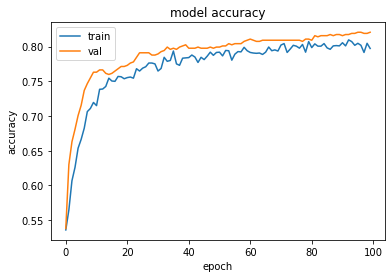

In [451]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

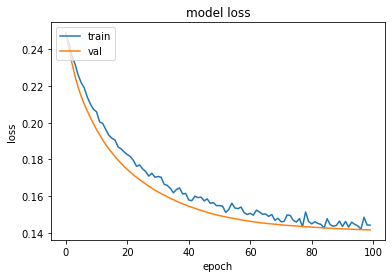

In [452]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### MLP Classifier NN

In [453]:
class_NN = MLPClassifier(
    hidden_layer_sizes=(32, 32, 32, 32, 32),
    activation='tanh',
    solver='adam',
    alpha=0.0001,
    learning_rate='adaptive',
    max_iter=1000, 
    verbose=0,
    random_state=random_state)
class_NN.fit(x_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(32, 32, 32, 32, 32),
              learning_rate='adaptive', max_iter=1000, random_state=2603,
              verbose=0)

In [454]:
y_pred = class_NN.predict(x_test)
mlp_acc = get_accuracy(y_pred, y_test)

Accuracy: 80.10%


In [455]:
x_test[0]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([11.,  9.,  4.], dtype=float32)>

### Grid Search to Find Optimal Parameters

In [456]:
params = {
    'hidden_layer_sizes' : [(64, 32, 32, 32, 16), (32, 32, 32, 32, 32)],
}

gscv = GridSearchCV(class_NN, params, verbose=1)

# gscv.fit(np.array(x_train), np.array(y_train))
# print(gscv.best_params_) 

### Analyze Results

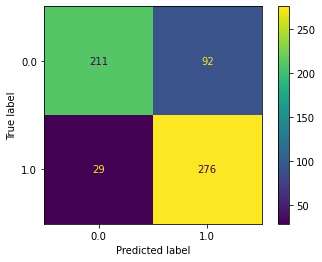

In [457]:
plot_confusion_matrix(class_NN, x_test, y_test)  
plt.show()

In [458]:
print(classification_report(y_pred, y_test, target_names=["CutFree", "CutFreeRL"]))

              precision    recall  f1-score   support

     CutFree       0.70      0.88      0.78       240
   CutFreeRL       0.90      0.75      0.82       368

    accuracy                           0.80       608
   macro avg       0.80      0.81      0.80       608
weighted avg       0.82      0.80      0.80       608



# Visualize Incorrect Classifications

In [459]:
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time
0,6,1,4,0,0.006211,0.228063
3,6,4,4,0,0.013531,0.150443
5,6,6,4,0,0.011498,0.194223
6,6,7,4,0,0.018870,0.205003
9,6,10,4,0,0.021175,0.262876


In [460]:
df_total["Discrepency"] = df_total.CutFree_Time - df_total.CutFreeRL_Time
df_total = df_total.sort_values(by=["Discrepency"], ascending=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time,Discrepency
5137,38,9,7,0,0.649197,3.664514,-3.015318
5084,37,6,7,0,0.082008,2.770018,-2.688011
5232,40,4,7,0,0.087409,2.598295,-2.510885
5234,40,6,7,0,0.101090,2.525037,-2.423947
2986,30,7,7,0,0.412753,2.758333,-2.345580


In [461]:
df_total_tf = df_total.copy()

df_total_tf.loc[x_test_df.index[np.where(y_test_df != y_pred_tf)], "Prediction"] = 0
df_total_tf.loc[df_total_tf["Prediction"].isna(), "Prediction"] = 1

df_total_tf = df_total_tf.reset_index(drop=True)


In [462]:
df_total.loc[x_test_df.index[np.where(y_test_df != y_pred)], "Prediction"] = 0
df_total.loc[df_total["Prediction"].isna(), "Prediction"] = 1


In [463]:
df_total = df_total.reset_index(drop=True)
df_total.head()

,OligoLength,TotalSites,SiteLength,Algorithm,CutFree_Time,CutFreeRL_Time,Discrepency,Prediction
0,38,9,7,0,0.649197,3.664514,-3.015318,1.0
1,37,6,7,0,0.082008,2.770018,-2.688011,1.0
2,40,4,7,0,0.087409,2.598295,-2.510885,1.0
3,40,6,7,0,0.101090,2.525037,-2.423947,0.0
4,30,7,7,0,0.412753,2.758333,-2.345580,1.0


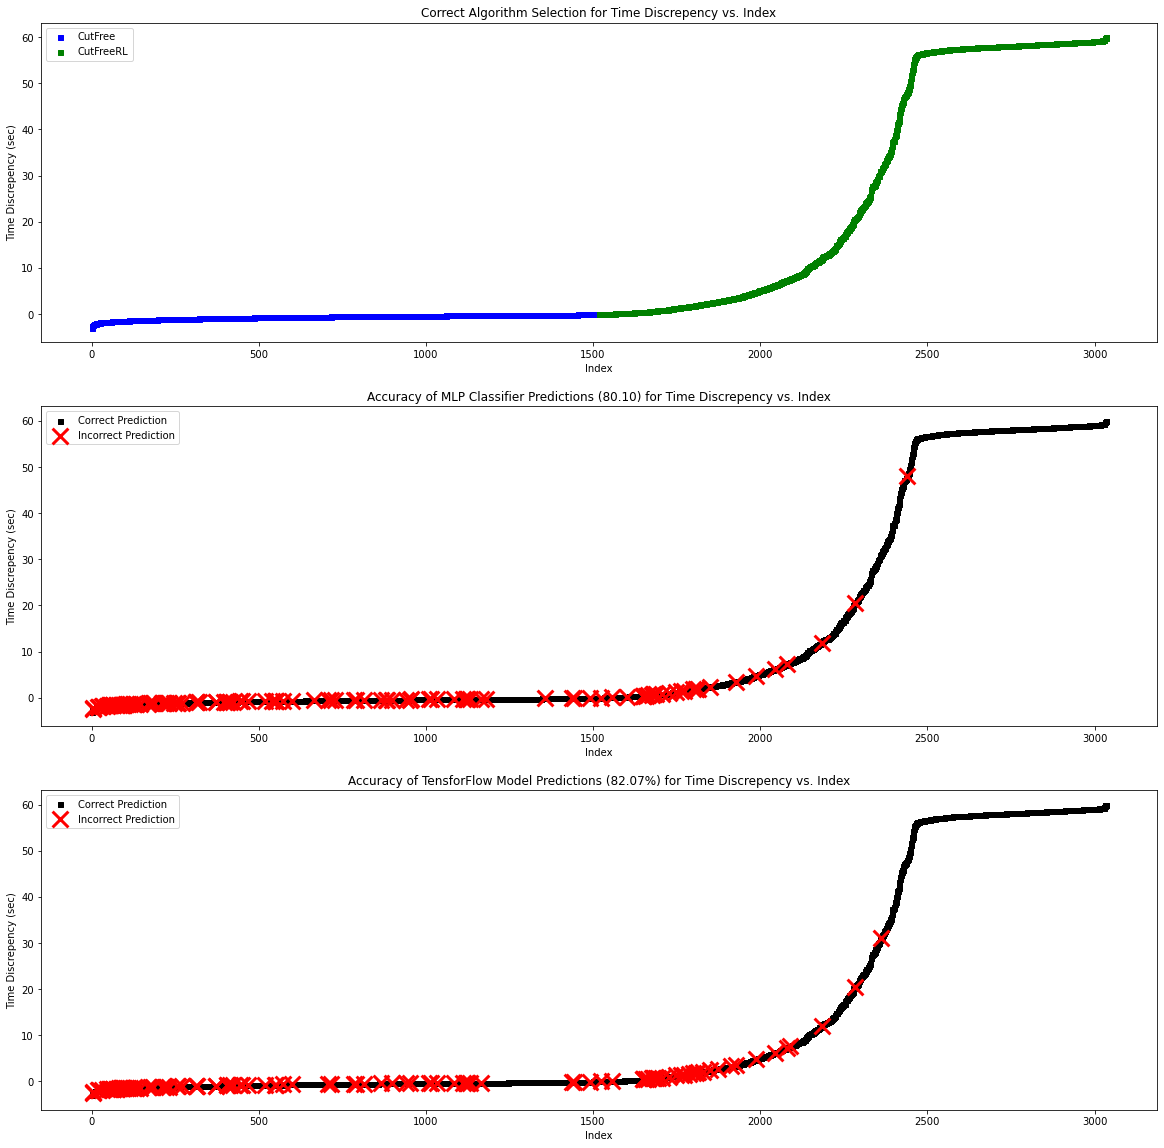

In [464]:
plt.figure(figsize=(20,20))

plt.subplot(311)
plt.scatter(
    df_total[df_total.Algorithm==0].index, df_total[df_total.Algorithm==0].Discrepency, 
    c ="blue",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Algorithm==1].index, df_total[df_total.Algorithm==1].Discrepency, 
    c ="green",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.title("Correct Algorithm Selection for Time Discrepency vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["CutFree", "CutFreeRL"])

plt.subplot(312)
plt.scatter(
    df_total[df_total.Prediction==1].index, df_total[df_total.Prediction==1].Discrepency, 
    c ="black",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total[df_total.Prediction==0].index, df_total[df_total.Prediction==0].Discrepency, 
    c ="red",
    linewidths = 3,
    marker ="x",
    s = 250)

plt.title(f"Accuracy of MLP Classifier Predictions ({mlp_acc:.2f}) for Time Discrepency vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["Correct Prediction", "Incorrect Prediction"])

plt.subplot(313)
plt.scatter(
    df_total_tf[df_total_tf.Prediction==1].index, df_total_tf[df_total_tf.Prediction==1].Discrepency, 
    c ="black",
    linewidths = 1,
    marker ="s",
    s = 25)

plt.scatter(
    df_total_tf[df_total_tf.Prediction==0].index, df_total_tf[df_total_tf.Prediction==0].Discrepency, 
    c ="red",
    linewidths = 3,
    marker ="x",
    s = 250)

plt.title(f"Accuracy of TensforFlow Model Predictions ({tf_acc:.2f}%) for Time Discrepency vs. Index")
plt.xlabel("Index")
plt.ylabel("Time Discrepency (sec)")
plt.legend(["Correct Prediction", "Incorrect Prediction"])


# Get Sensitivity

In [465]:
false_positives = df_total[df_total.Prediction==0].CutFree_Time > 60
false_positives = false_positives[false_positives==True].count()

true_positives = df_total[df_total.Prediction==1].CutFree_Time > 60
true_positives = true_positives[true_positives==True].count()

sensitivity = true_positives / (true_positives + false_positives)
sensitivity

1.0

In [466]:
with open("sensitivity_results.csv", "a") as f:
    writer = csv.writer(f)
    writer.writerow([sensitivity])

In [487]:
average_sensitivity = np.array([])
n = 0

with open("sensitivity_results.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        if row != []:
            average_sensitivity = np.append(average_sensitivity, float(row[0]))
            n += 1

print(f"Average Sensitivity: {average_sensitivity.mean():.5f} +/- {average_sensitivity.std():.5f}")
print(f"Number of Trials: {n}")

Average Sensitivity: 0.99876 +/- 0.00139
Number of Trials: 10


# Save Model

In [467]:
# with open("cutfree_model.pkl", "wb") as f:
#     pickle.dump(class_NN, f)

In [468]:
# with open("../cutfree-models/cutfree_model.pkl", "rb") as f:
#     model = pickle.load(f)
# model.predict([[6, 1, 4]])